### preparing the dataset

In [14]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

In [2]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [4]:
train_images.shape, test_images.shape

((60000, 28, 28), (10000, 28, 28))

In [5]:
train_labels

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [6]:
type(train_labels)

numpy.ndarray

In [7]:
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [8]:
# Reshape to 3 channels and normalize
train_images = np.stack([train_images]*3, axis=-1) / 255.0
test_images = np.stack([test_images]*3, axis=-1) / 255.0

In [9]:
train_images.shape,test_images.shape

((60000, 28, 28, 3), (10000, 28, 28, 3))

In [ ]:

# Resize images to 32x32
train_images = tf.image.resize(train_images, [32, 32])
test_images = tf.image.resize(test_images, [32, 32])

2025-01-10 11:48:06.579967: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [12]:
train_images.shape,test_images.shape

(TensorShape([60000, 32, 32, 3]), TensorShape([10000, 32, 32, 3]))

In [15]:
# Convert labels to one-hot encoding
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)

In [16]:
train_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

## Building the model

In [17]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

In [18]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
base_model.trainable = False  # Freeze base model

/tmp/ipykernel_11189/3368834505.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [19]:
inputs = Input(shape=(32, 32, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
outputs = Dense(10, activation='softmax')(x)
model = Model(inputs, outputs)

## compiling and training the model

In [20]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=10, validation_split=0.2)


Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 26s 17ms/step - accuracy: 0.4515 - loss: 1.8271 - val_accuracy: 0.6050 - val_loss: 1.2952
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 28s 19ms/step - accuracy: 0.6050 - loss: 1.2581 - val_accuracy: 0.6407 - val_loss: 1.1387
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 27s 18ms/step - accuracy: 0.6374 - loss: 1.1314 - val_accuracy: 0.6538 - val_loss: 1.0713
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - accuracy: 0.6511 - loss: 1.0767 - val_accuracy: 0.6608 - val_loss: 1.0358
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 27s 18ms/step - accuracy: 0.6565 - loss: 1.0404 - val_accuracy: 0.6647 - val_loss: 1.0144
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 28s 19ms/step - accuracy: 0.6594 - loss: 1.0292 - val_accuracy: 0.6693 - val_loss: 0.9999
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 28s 19ms/step - accuracy: 0.6620 - loss: 1.0111 - val_accuracy: 0.6708 - val_loss: 0.9898
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 28s 19ms/step - accuracy: 0.6663 -

## fine-tuning the model

In [22]:
# Unfreeze some layers for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

# Compile with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=5, validation_split=0.2)


Epoch 1/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 135s 87ms/step - accuracy: 0.8025 - loss: 0.6683 - val_accuracy: 0.8800 - val_loss: 0.4242
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 133s 88ms/step - accuracy: 0.8408 - loss: 0.5273 - val_accuracy: 0.8967 - val_loss: 0.3516
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 133s 89ms/step - accuracy: 0.8565 - loss: 0.4828 - val_accuracy: 0.9020 - val_loss: 0.3256
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 133s 89ms/step - accuracy: 0.8737 - loss: 0.4282 - val_accuracy: 0.9078 - val_loss: 0.3144
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 134s 89ms/step - accuracy: 0.8859 - loss: 0.3801 - val_accuracy: 0.9180 - val_loss: 0.2698


## model evaluation

In [23]:
loss, accuracy = model.evaluate(test_images, test_labels)
print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9065 - loss: 0.3140
Test loss: 0.2818982005119324
Test accuracy: 0.9165999889373779


## visualizing the model performance

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step


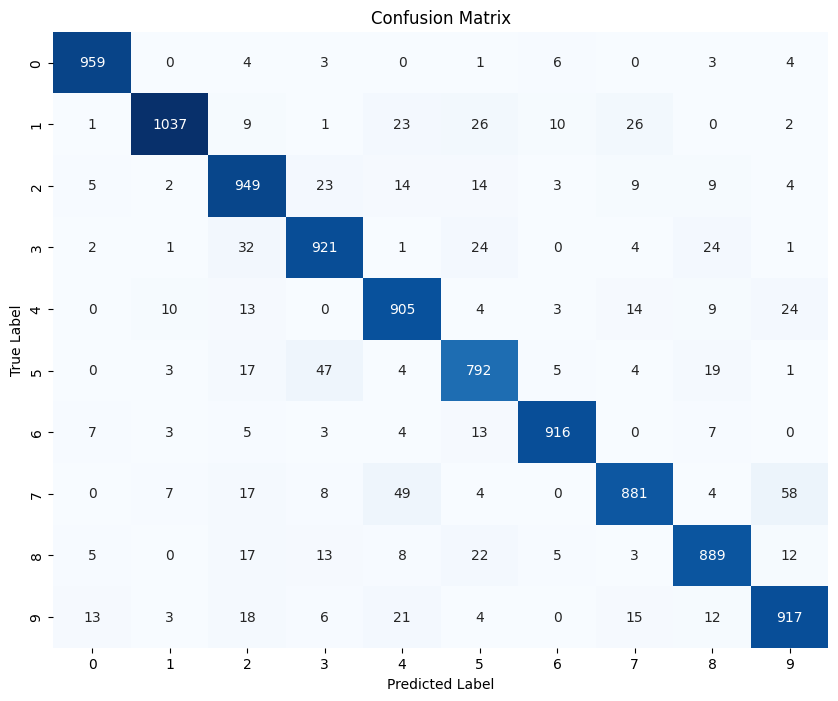

In [27]:
import sklearn
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate predictions
test_predictions = model.predict(test_images)
test_predictions_classes = np.argmax(test_predictions, axis=1)
test_true_classes = np.argmax(test_labels, axis=1)

# Plot confusion matrix
cm = confusion_matrix(test_true_classes, test_predictions_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


## sample image visualization

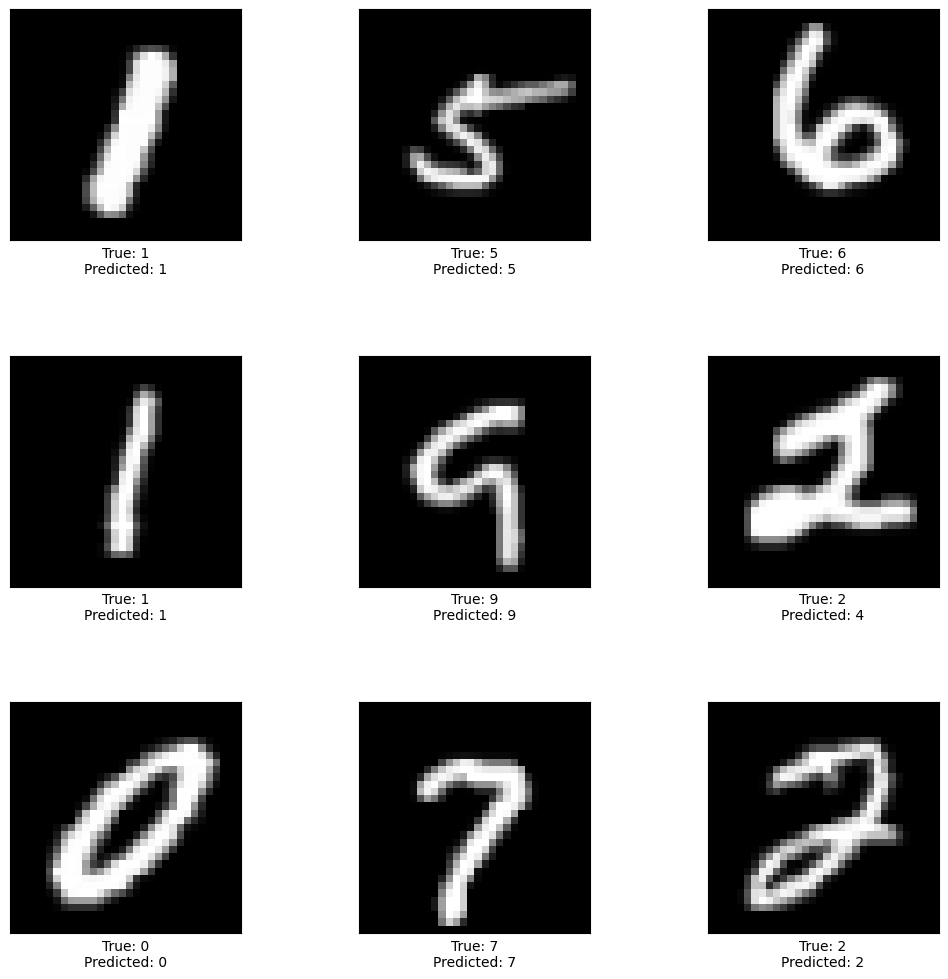

In [28]:
def display_sample(sample_images, sample_labels, sample_predictions):
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)

    for i, ax in enumerate(axes.flat):
        ax.imshow(sample_images[i].reshape(32, 32), cmap='gray')
        ax.set_xlabel(f"True: {sample_labels[i]}\nPredicted: {sample_predictions[i]}")
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

# Convert RGB to grayscale for visualization
test_images_gray = np.dot(test_images[...,:3], [0.2989, 0.5870, 0.1140])

# Select and display a sample
random_indices = np.random.choice(len(test_images_gray), 9, replace=False)
sample_images = test_images_gray[random_indices]
sample_labels = test_true_classes[random_indices]
sample_predictions = test_predictions_classes[random_indices]
display_sample(sample_images, sample_labels, sample_predictions)
